Assumoption:
- A1: Have model
- A2: Have all images arr loaded from transformed

Steps:
- S1: Split trian and test
- S2: Remove classfication layer (last 2 layer)
- S3: Predict all test images (result as encoded array) aka feature vectors 
- S4: Build KDTree index
- S5: find similar images

In [2]:
# def get_existed_df() -> pd.DataFrame:
#     parquet_file = pq.ParquetFile('./data/img.parquet')
#     df = None
    
#     for batch in parquet_file.iter_batches(batch_size=1000):
#         batch_df = batch.to_pandas()
#         df = pd.concat([batch_df, df]) if df is not None else batch_df
        
#         print(len(batch_df), len(df))

#     return df



# persist_path = './data/img.parquet'
# if os.path.exists(persist_path):
#     df_sim = get_existed_df()
# else:
#     df_sim = get_df_manually()
#     df_sim.to_parquet(persist_path)


### [Deprecated] Calculate similarity features for later similarity computation

In [25]:
bins = 88

def get_histogram(image: np.ndarray):
    histogram = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram 

def get_texture_feature(image: np.ndarray):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = texture.haralick(gray_image)
    return np.mean(glcm, axis=0)

def get_compactness(image: np.ndarray):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding
    thresholded = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate compactness for each contour
    compactness_values = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        compactness = perimeter / np.sqrt(area) if area > 0 else 0
        compactness_values.append(compactness)
    
    # Maximum Compactness: Choose the contour with the highest compactness value. 
    # This approach assumes that the object with the highest compactness is the most significant or relevant in the image.
    max_compactness_index = np.argmax(compactness_values)
    max_compactness_value = compactness_values[max_compactness_index]
    
    return max_compactness_value


# def get_similarity_attrs(row: pd.Series) -> pd.Series: 
#     print(row['path'])
#     image = cv2.imread(row['path'])

#     row['histogram'] = get_histogram(image)
#     row['texture_feature'] = get_texture_feature(image)
#     row['compactness'] = get_compactness(image)

#     return row 

# def get_similarity_attrs(path):
#     image = cv2.imread(path)
def get_similarity_attrs(image):
    histogram = get_histogram(image)
    texture_feature = get_texture_feature(image)
    compactness = get_compactness(image)
    return pd.Series([histogram, texture_feature, compactness], index=['histogram', 'texture_feature', 'compactness'])

In [ ]:
# Create new columns to store the results (take abt 1 hour to complete)
# df_sim[['histogram', 'texture_feature', 'compactness']] = df_sim['path'][:20].progress_apply(get_similarity_attrs)
df_test = df_sim['img_arr'][:20].progress_apply(get_similarity_attrs)

In [ ]:
# !pip install git+https://github.com/openai/CLIP.git
# !pip install open_clip_torch
# !pip install sentence_transformers

# import torch
# import open_clip
# import cv2
# from sentence_transformers import util
# from PIL import Image

# image processing model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)
def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1
def generateScore(image1, image2):
    test_img = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    data_img = cv2.imread(image2, cv2.IMREAD_UNCHANGED)
    img1 = imageEncoder(test_img)
    img2 = imageEncoder(data_img)
    cos_scores = util.pytorch_cos_sim(img1, img2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score
print(f"similarity Score: ", round(generateScore(image1, image2), 2))
#similarity Score: 76.77

## Dependencies

In [14]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import tensorflow.image as imtf
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import mahotas.features.texture as texture
import pyarrow
import pyarrow.parquet as pq
from PIL import Image
import matplotlib.pyplot as plt
import pickle

tqdm.pandas()

## Training (Skip this step if you've already trained your model)

### Read Data

In [2]:
# Load Dataset
data_file_path = "./data/transforms.parquet"
df = pd.read_parquet(data_file_path)

# Note: Numpy array is treated as string here 
df['path'] = df['path'].str.replace('Furniture_Data','Transformed_Furniture_Data')
df.head()

,path,furniture,style
0,./Transformed_Transformed_Furniture_Data/table...,table,eclectic
1,./Transformed_Transformed_Furniture_Data/table...,table,eclectic
2,./Transformed_Transformed_Furniture_Data/table...,table,eclectic
3,./Transformed_Transformed_Furniture_Data/table...,table,eclectic
4,./Transformed_Transformed_Furniture_Data/table...,table,eclectic


In [3]:
df.shape

(544986, 3)

In [ ]:
def get_image(img_path):
    img_arr = cv2.imread(img_path)
    
    # Downsize image for faster model training. BB
    # Normalize the image to scale 0-1 for faster training time and better performance
    return cv2.resize(img_arr, (50,50)) / 255.0 

# Get img arr 
X = df['path'].progress_apply(lambda path: get_image(path))
X = np.array(X.to_list())


In [179]:
# Define Label
def get_index(furniture):
    return furniture_indexes[furniture]

# Define furniture index. We'll use this data format as target for training 
furniture_indexes = {furniture:idx for idx, furniture in enumerate(df['furniture'].unique(), 1)}
print(furniture_indexes)

y = df['furniture'].apply(lambda furniture: get_index(furniture)).to_list()
y = np.array(y)


{'table': 1, 'sofa': 2, 'lamp': 3, 'chair': 4, 'dresser': 5, 'bed': 6}


In [20]:
X.shape

(90082, 50, 50, 3)

### Training

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Using stratify on y to ensure better distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train)
X_test = np.squeeze(X_test)
y_test = np.squeeze(y_test)

In [9]:
print(f"X_train shape {X_train.shape}")
print(f"X_test shape {X_test.shape}")

X_train shape (109474, 50, 50, 3)
X_test shape (72983, 50, 50, 3)


In [10]:
print(f"y_train shape {y_train.shape}")
print(f"y_test shape {y_test.shape}")

y_train shape (109474,)
y_test shape (72983,)


In [11]:
from tensorflow.keras import layers, models, regularizers

# Create a sequential model
model = models.Sequential()

# Add convolutional layers
# model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224,3),kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50,3), padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(512*2*2, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))



# Add a dense layer
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.2)) # add a dropout layer with dropout rate of 0.2


# Add the output layer
model.add(layers.Dense(64, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5


2024-04-30 13:58:25.130468: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3422/3422 [==============================] - 81s 24ms/step - loss: 0.5017 - accuracy: 0.8230 - val_loss: 0.3039 - val_accuracy: 0.8983
Epoch 2/5
3422/3422 [==============================] - 74s 22ms/step - loss: 0.2658 - accuracy: 0.9104 - val_loss: 0.2659 - val_accuracy: 0.9150
Epoch 3/5
3422/3422 [==============================] - 73s 21ms/step - loss: 0.2088 - accuracy: 0.9304 - val_loss: 0.2210 - val_accuracy: 0.9261
Epoch 4/5
3422/3422 [==============================] - 66s 19ms/step - loss: 0.1738 - accuracy: 0.9420 - val_loss: 0.2074 - val_accuracy: 0.9320
Epoch 5/5
3422/3422 [==============================] - 66s 19ms/step - loss: 0.1496 - accuracy: 0.9489 - val_loss: 0.1728 - val_accuracy: 0.9444


## Predict

#### Load Model

In [21]:
# load model
from tensorflow.keras import models

model_dir = "./models"
model_h5_file = os.path.join(model_dir, "model_task_2_cnn_classification.h5")

model = models.load_model(model_h5_file)
model

In [22]:
# (Adhoc) Remove the last 2 layers for better encoding (according to ChatGPT) 
encoder = models.Sequential()
for layer in model.layers[:-2]:  # Exclude the last two layers (flatten and dense)
    encoder.add(layer)
encoder

### Define util function and list of furnitures

In [18]:
data_file_path = "./data/raws.parquet"
df_sample = pd.read_parquet(data_file_path)

furnitures = df_sample['furniture'].unique()

def get_image_and_resize(img_path):
    
    img_arr = cv2.imread(img_path)
    
    # Downsize image for faster model training. BB
    # Normalize the image to scale 0-1 for faster training time and better performance
    return cv2.resize(img_arr, (100,100)) / 255.0 

In [114]:
furnitures

array(['table', 'sofa', 'lamp', 'chair', 'dresser', 'bed'], dtype=object)

### Calculate feature vectors and persist to disk(Skip if you have persisted feature vectors)

In [115]:
import pickle
vector_dir = "./vectors"

def persist_vector(furniture, vector_tuples):
    vector_file = os.path.join(vector_dir, f"{furniture}_vector.pkl")
    
    
    if not os.path.exists(vector_dir):
        os.makedirs(vector_dir)
    
    with open(vector_file, 'wb') as file:
        pickle.dump(vector_tuples, file)

    print(f"Persist {furniture} vector to {vector_file}")
    
    # # Load vectors
    # vector_file = './vectors/lamp_vector.pkl'
    
    # with open(vector_file, 'rb') as file:
    #     loaded_vector = pickle.load(file)

In [116]:
# Calculate feature vectors and persist 
data_file_path = "./data/raws.parquet"
df_sample = pd.read_parquet(data_file_path)

for fur in tqdm(furnitures):
    # Extract images for the furniture
    df_fur = df_sample.query(f"furniture == '{fur}'").head(200)
    arr_img_fur = df_fur['path'].progress_apply(lambda path: get_image_and_resize(path))

    # Calculate feature vector 
    feature_vectors = [encoder.predict(np.expand_dims(img, axis=0)).flatten()  for img in tqdm(arr_img_fur)]
    feature_vectors =  np.array(feature_vectors)

    # Map feature vectors and path into one tuple 
    img_paths = df_fur['path'].to_list()
    vector_tuples = [(feature_vector, img_path) for feature_vector, img_path in zip(feature_vectors, img_paths)]
    
    # Persist 
    persist_vector(fur, vector_tuples)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step
Persist table vector to ./vectors_test/table_vector.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step
Persist sofa vector to ./vectors_test/sofa_vector.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step
Persist lamp vector to ./vectors_test/lamp_vector.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step
Persist chair vector to ./vectors_test/chair_vector.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step
Persist dresser vector to ./vectors_test/dresser_vector.pkl


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step
Persist bed vector to ./vectors_test/bed_vector.pkl


Use the encoder to encode the image for betterđ vector search

### Recommend using KDtree

In [25]:
from sklearn.neighbors import KDTree

def unnest_feature_vector_mapping(mapped_tuples):
    feature_vectors, paths = zip(*mapped_tuples) 
    return list(feature_vectors), list(paths)
    
def load_category_data(category):
    vector_file = os.path.join('./vectors', f'{category}_vector.pkl')
    
    with open(vector_file, 'rb') as file:
        data = pickle.load(file)

    feature_vectors_list, paths_list = unnest_feature_vector_mapping(data)
        
    # Build KDTree index
    kdtree_index = KDTree(feature_vectors_list)
    return kdtree_index, paths_list

# Function to find similar images for a given query image
def find_similar_images(query_image_path, top_k=5):

    # Preprocess query image
    query_img = get_image_and_resize(query_image_path)

    # get the image cat
    predicted_category_index = model.predict(np.expand_dims(query_img, axis=0)).argmax()
    predicted_category = furnitures[predicted_category_index - 1]
    print(predicted_category)

    # Load corresponding vectors from the vectors folder
    kdtree_index, img_paths = load_category_data(predicted_category)

    # Encode input image to feature vector
    query_features = encoder.predict(np.expand_dims(query_img, axis=0)).flatten() 

    # Perform nearest neighbor search using KDTree index
    distances, indices = kdtree_index.query(query_features.reshape(1, -1), k=top_k)

    similarity_scores = 1 / (1 + distances)
    
    # Return paths of similar images
    similar_image_paths = [img_paths[idx] for idx in indices[0]]
    return similar_image_paths, distances, similarity_scores

In [20]:
furnitures

array(['table', 'sofa', 'lamp', 'chair', 'dresser', 'bed'], dtype=object)

Input a random image and check for similar images

1/1 [==============================] - 0s 140ms/step
bed
1/1 [==============================] - 0s 19ms/step


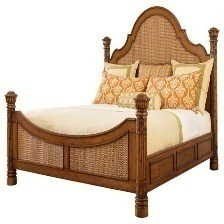

In [38]:
# input_img_path = './Custom_Furniture_Data/custom-img-4.png'
# input_img_path = './Furniture_Data/beds/Rustic/4929rustic-panel-beds.jpg'
input_img_path = './Furniture_Data/beds/Tropical/10435tropical-panel-beds.jpg'
# input_img_path = './Furniture_Data/sofas/Beach/2674beach-style-sofas.jpg'

paths, distances, similarity_scores = find_similar_images(input_img_path, 10)
Image.open(input_img_path)

In [41]:
# Adhoc for Triet's device: Replace root dir
paths = [path.replace('task1-2-furnitures','Furniture_Data') for path in paths]
paths

['./Furniture_Data/beds/Tropical/10435tropical-panel-beds.jpg',
 './Furniture_Data/beds/Traditional/7349traditional-panel-beds.jpg',
 './Furniture_Data/beds/Farmhouse/8352farmhouse-panel-beds.jpg',
 './Furniture_Data/beds/Traditional/7291traditional-panel-beds.jpg',
 './Furniture_Data/beds/Traditional/7466traditional-platform-beds.jpg',
 './Furniture_Data/beds/Traditional/6254traditional-panel-beds.jpg',
 './Furniture_Data/beds/Beach/8146beach-style-panel-beds.jpg',
 './Furniture_Data/beds/Victorian/10498victorian-sleigh-beds.jpg',
 './Furniture_Data/beds/Victorian/10445victorian-panel-beds.jpg',
 './Furniture_Data/beds/Farmhouse/33658farmhouse-panel-beds.jpg']

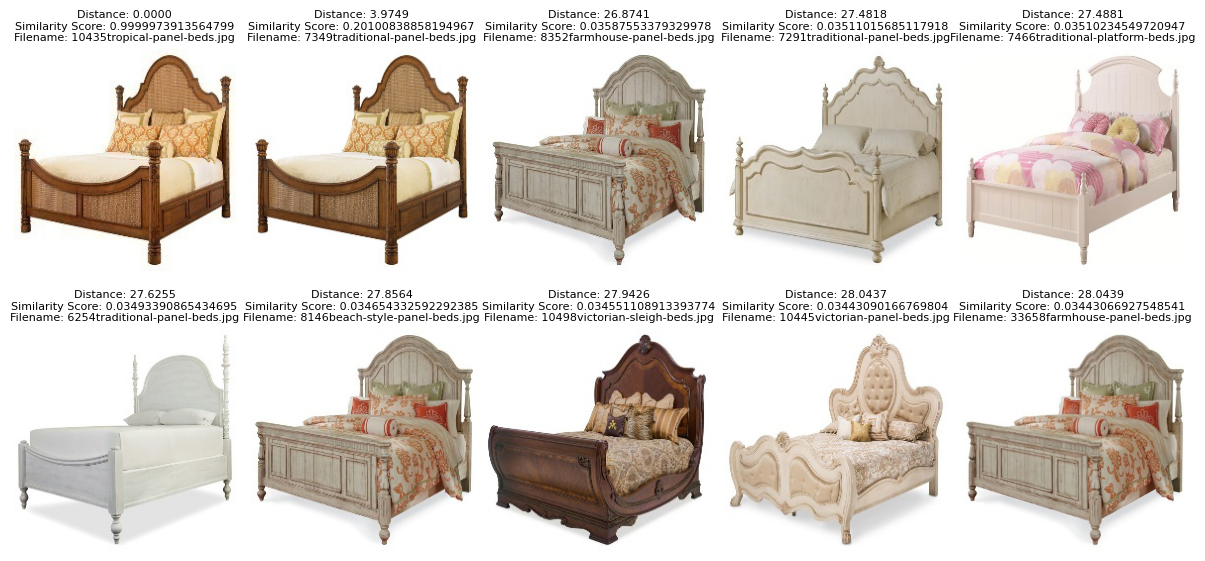

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for index, image_path in enumerate(paths):
    
    image = Image.open(image_path)
    axes[index].imshow(image)
    axes[index].axis('off')  # Turn off axis numbers and ticks

    file_name = os.path.basename(image_path)

    # Add the similarity score label
    distance = distances[0, index]
    similarity_score = similarity_scores[0, index]
    axes[index].set_title(f"Distance: {distance:.4f}\nSimilarity Score: {similarity_score}\nFilename: {file_name}", fontsize=8)

plt.tight_layout()
plt.show()

## Evaluation

1. Extract histogram from input image and predicted images
2. Compare using Pearson correlation

### Histogram Comparsion

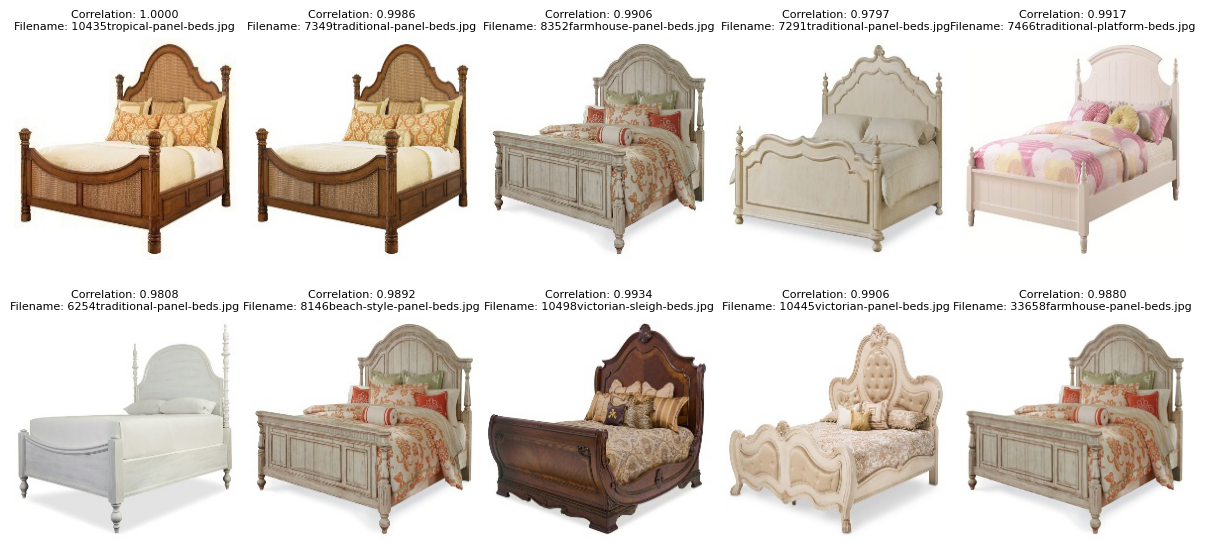

In [94]:
from scipy.stats import pearsonr

# Get histogram for input image
input_img_arr = cv2.imread(input_img_path)
input_hist = get_histogram(input_img_arr)

# Draw pictures
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for index, path in enumerate(paths):
    # Show image
    image = Image.open(path)
    axes[index].imshow(image)
    axes[index].axis('off')  # Turn off axis numbers and ticks

    file_name = os.path.basename(path)
    
    # Get histogram 
    neighbor_img_arr = cv2.imread(path)
    neighbor_hist = get_histogram(neighbor_img_arr)

    # Get correlation 
    correlation_coefficient, _ = pearsonr(input_hist, neighbor_hist)


    # similarity_score = similarity_scores[0, index]

    axes[index].set_title(f"Correlation: {correlation_coefficient:.4f}\nFilename: {file_name}", fontsize=8)
    index += 1

plt.tight_layout()
plt.show()

### [Deprecated] Calculate similarity features for later similarity computation

In [95]:
bins = 88

def get_histogram(image: np.ndarray):
    # Convert to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate histograms
    histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    
    return cv2.normalize(histogram, None).flatten()

def get_texture_feature(image: np.ndarray):
    gray_image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    glcm = texture.haralick(gray_image)
    return np.mean(glcm, axis=0)

def get_compactness(image: np.ndarray):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding
    thresholded = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate compactness for each contour
    compactness_values = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        compactness = perimeter / np.sqrt(area) if area > 0 else 0
        compactness_values.append(compactness)
    
    # Maximum Compactness: Choose the contour with the highest compactness value. 
    # This approach assumes that the object with the highest compactness is the most significant or relevant in the image.
    max_compactness_index = np.argmax(compactness_values)
    max_compactness_value = compactness_values[max_compactness_index]
    
    return max_compactness_value

def get_similarity_attrs(image):
    histogram = get_histogram(image)
    texture_feature = get_texture_feature(image)
    compactness = get_compactness(image)
    return pd.Series([histogram, texture_feature, compactness], index=['histogram', 'texture_feature', 'compactness'])

In [136]:
sim_attrs = [get_similarity_attrs(image) for image in tqdm(arr_imgs)]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [199]:
input_img_path = './Custom_Furniture_Data/custom-img-2.png'

input_arr = get_image_and_resize(input_img_path)
input_arr = np.expand_dims(input_arr, axis=0) / 255
prediction_idx = np.argmax(model.predict(input_arr))

1/1 [==============================] - 0s 125ms/step


In [205]:
# Get sim_attr of the input 
# input_img_path
input_attr = get_similarity_attrs(get_image_and_resize(input_img_path))

# Define the number of similar images to retrieve
k = 10

# Perform nearest neighbor search based on feature vectors
similar_images = []


predicted_arr_paths = arr_paths[2000*prediction_idx:2000*prediction_idx+2000]
predicted_sim_attrs = sim_attrs[2000*prediction_idx:2000*prediction_idx+2000]


# for image_file, sim_attr in tqdm(zip(predicted_arr_paths, predicted_sim_attrs)) :

for image_file, sim_attr in tqdm(zip(arr_paths, sim_attrs)) :
    histogram  = sim_attr['histogram']
    texture_feature  = sim_attr['texture_feature']
    compactness  = sim_attr['compactness']


    query_histogram  = input_attr['histogram']
    query_texture_feature  = input_attr['texture_feature']
    query_compactness  = input_attr['compactness']

    
    # Calculate the distance between the query image features and the current image features
    color_distance = cv2.compareHist(query_histogram, histogram, cv2.HISTCMP_CHISQR)
    texture_distance = np.linalg.norm(query_texture_feature - texture_feature)
    shape_distance = np.abs(query_compactness - compactness)
    distance = color_distance + texture_distance + shape_distance

    similar_images.append((image_file, distance))

similar_images.sort(key=lambda x: x[1])

0it [00:00, ?it/s]

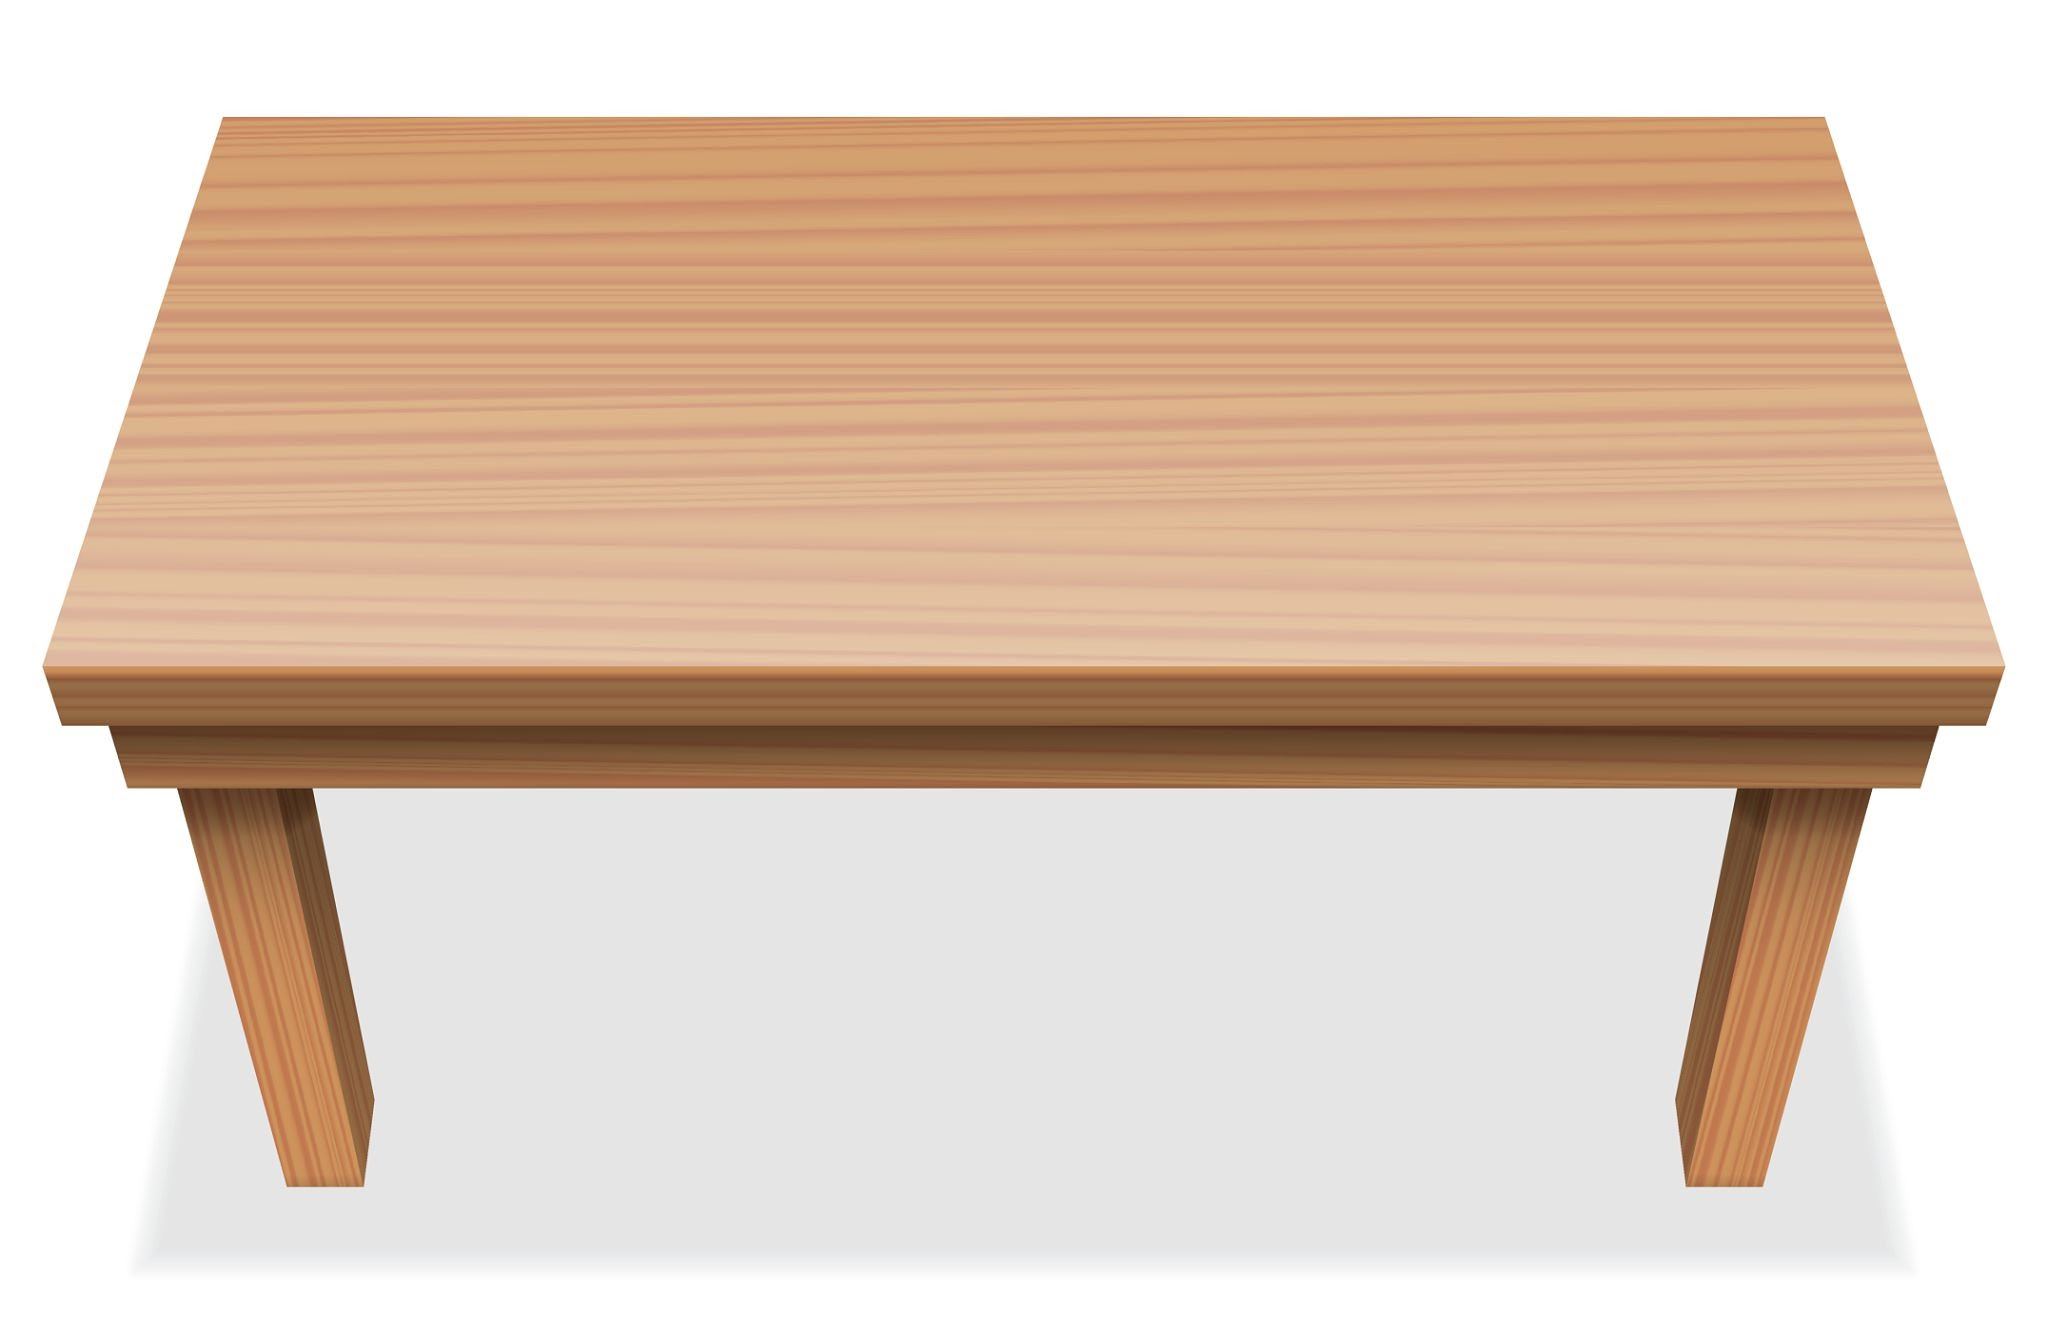

In [201]:
Image.open(input_img_path)

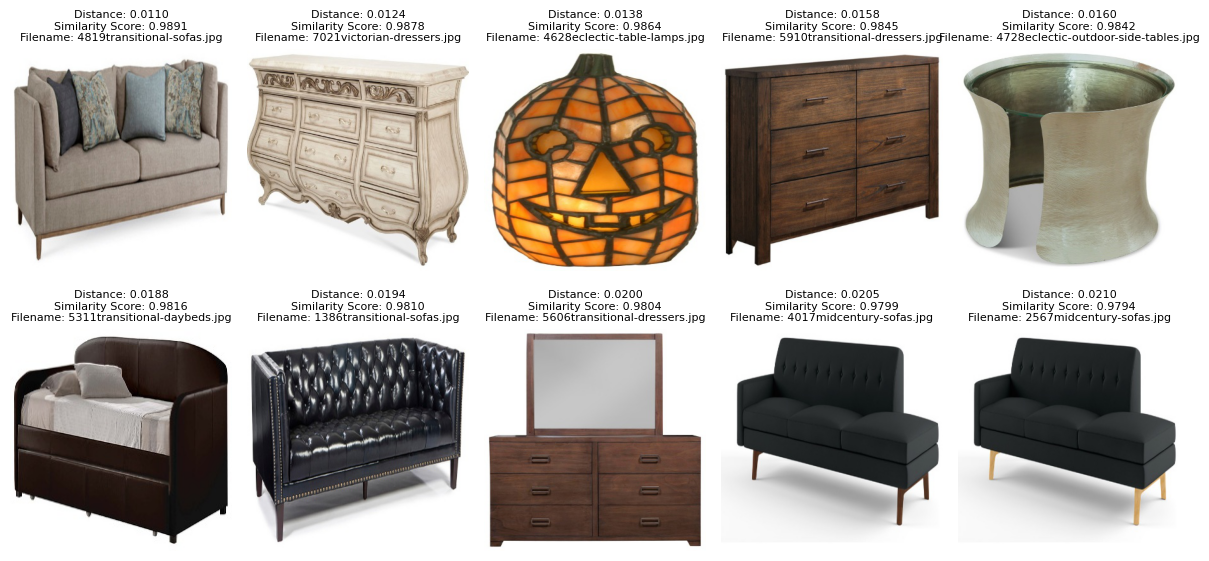

In [208]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

similar_images = sorted(similar_images, key=lambda x: x[1], reverse=False)
index = 0 

for image_path, distance in similar_images[:k]:
    image = Image.open(image_path)
    axes[index].imshow(image)
    axes[index].axis('off')  # Turn off axis numbers and ticks

    file_name = os.path.basename(image_path)

    # Add the similarity score label
    # similarity_score = similarity_scores[0, index]
    similarity_score = 1 / (1+distance)
    axes[index].set_title(f"Distance: {distance:.4f}\nSimilarity Score: {similarity_score:.4f}\nFilename: {file_name}", fontsize=8)
    # axes[index].set_title(f"Distance: {distance:.4f}\nFilename: {file_name}", fontsize=8)
    index += 1

plt.tight_layout()
plt.show()

## Post execution

### Save similarity dataset

In [ ]:
# Define the directory to save the model
def save_dataset(df: pd.DataFrame, data_file_name: str) -> None:
    data_dir = "./data"
    data_file_path = os.path.join(data_dir, data_file_name)
    
    # Check if the directory exists, and if not, create it
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    df.to_parquet(data_file_path, index=False, engine='pyarrow')
    print(f"Saved DataFrame to {data_file_path}")

data_file_name = "similarities.parquet"
save_dataset(dummy, data_file_name)

### Save model 

In [12]:
model_dir = "./models"
model_h5_file = os.path.join(model_dir, "model_task_2_cnn_classification.h5")

# Check if the directory exists, and if not, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model.save(model_h5_file)

### Save feature vector (hard code)

In [ ]:
import pickle
vector_dir = "./vectors"
vector_file = os.path.join(vector_dir, "lamp_vector.pkl")


if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open(vector_file, 'wb') as file:
    pickle.dump(mapped_tuples, file)

# Load vectors
vector_file = './vectors/lamp_vector.pkl'

with open(vector_file, 'rb') as file:
    loaded_vector = pickle.load(file)